<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Разделение-на-выборки" data-toc-modified-id="Разделение-на-выборки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Разделение на выборки</a></span></li><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#LGBM" data-toc-modified-id="LGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LGBM</a></span></li><li><span><a href="#Decision-Tree-Regressor" data-toc-modified-id="Decision-Tree-Regressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Decision Tree Regressor</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Загрузим необходимые библиотеки:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

Прочитаем файл, назначив даты индексами, и выведем первы епять строк для того, чтобы проверитьуспешность этой затеи:

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Выведем общую информацию о датафрейме, проверим его на пропуски:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.isna().sum()

num_orders    0
dtype: int64

Отсортируем индексы и проверим, идут ли они по порядку:

In [5]:
df.sort_index(inplace=True)

In [6]:
df.index.is_monotonic

True

Предобработка практически завершена! Ресемплируем данные по часу и начнем анализ данных:

In [7]:
df = df.resample('1H').sum()

## Анализ

Посмотрим на временной ряд в целом, а также выведем средние по часам, дням и неделям:

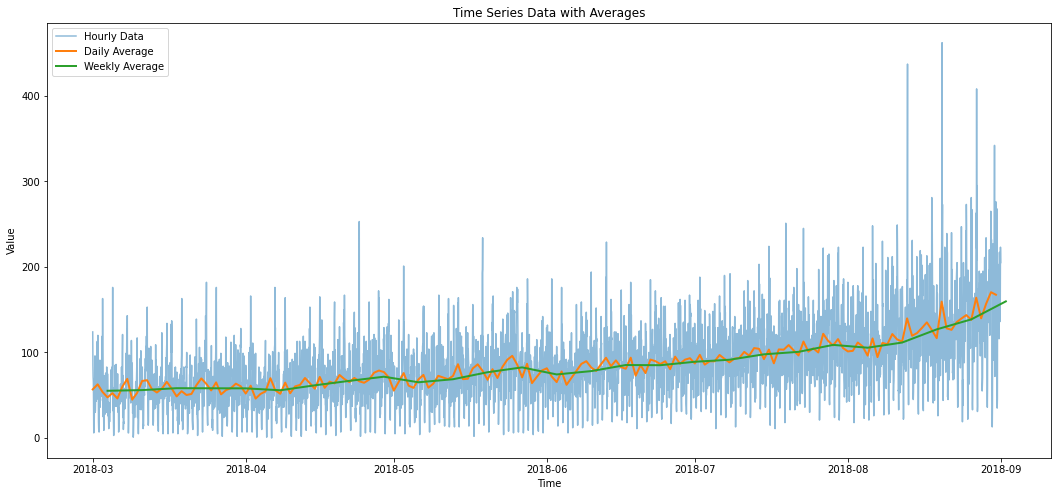

In [8]:
hourly_df = df.resample('H').mean()
daily_avg = hourly_df.resample('D').mean()
weekly_avg = hourly_df.resample('W').mean()

plt.figure(figsize=(18, 8))

plt.plot(hourly_df, label='Hourly Data', alpha=0.5)
plt.plot(daily_avg, label='Daily Average', linewidth=2)
plt.plot(weekly_avg, label='Weekly Average', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data with Averages')
plt.legend()
plt.show()

Видно, что количество заказов такси увеличивается, а также присутствуют явные колебания.

Определим функцию для построения графиков:

In [9]:
sns.set(rc={'figure.figsize':(18,8)})

def lineplot(data, title):
    data.plot()
    plt.title(title)
    plt.show()

In [10]:
decomposed = seasonal_decompose(df)

Наконец, посмотрим на визуалицию данных:

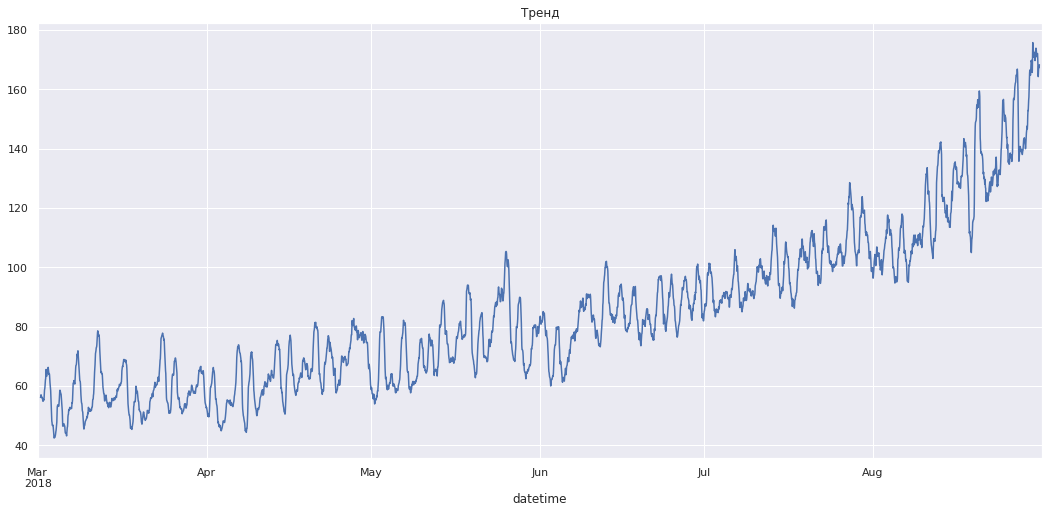

In [11]:
lineplot(decomposed.trend, 'Тренд')

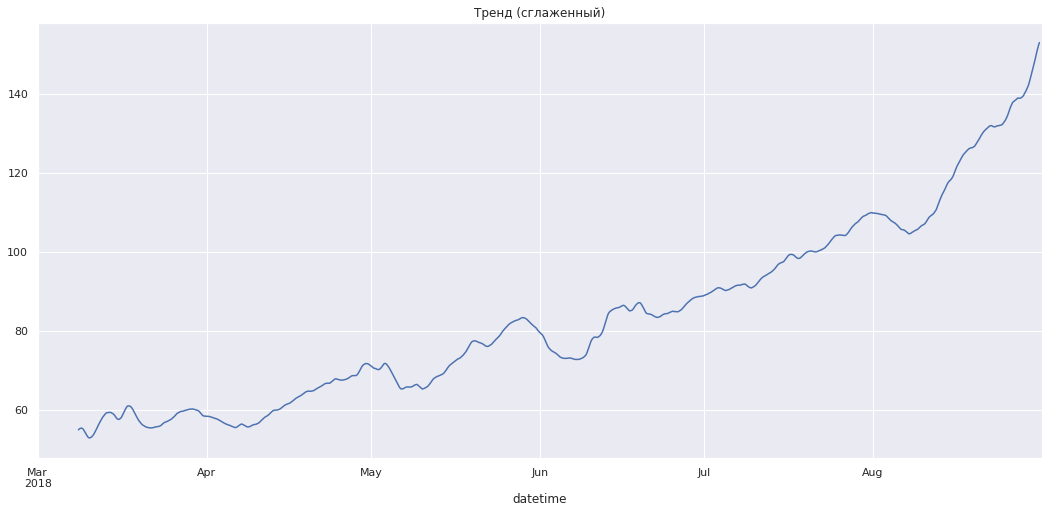

In [12]:
lineplot(decomposed.trend.rolling(24*7).mean(), 'Тренд (сглаженный)')

Из графиков видно, что тренд восходящий, что говорит об увеличении количества заказов. Посмотрим на сезонность данных в течение дня:

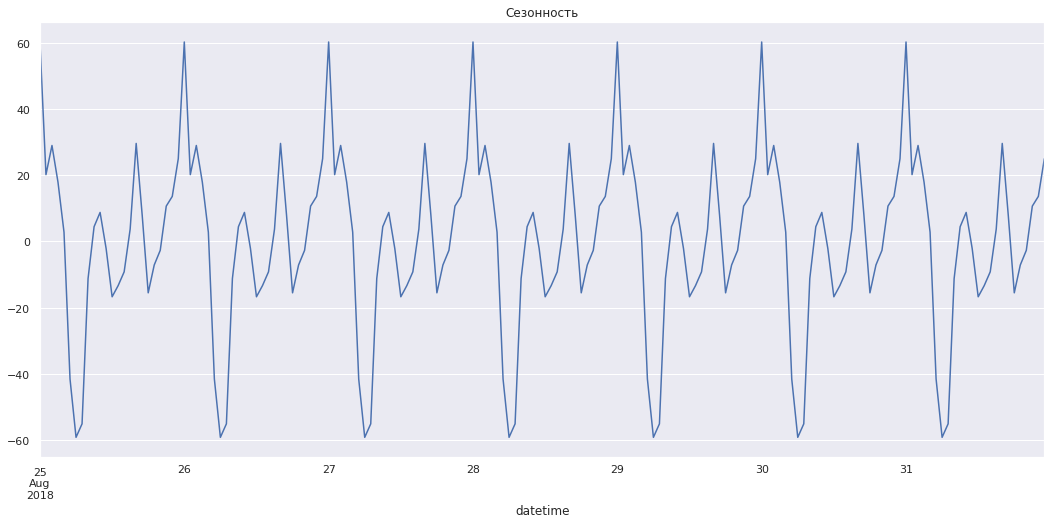

In [13]:
lineplot(decomposed.seasonal.tail(24*7), 'Сезонность')

Очевидным становится факт того, что пик заказов - ночное время, а их минимальное значение приходится на часы под утро.

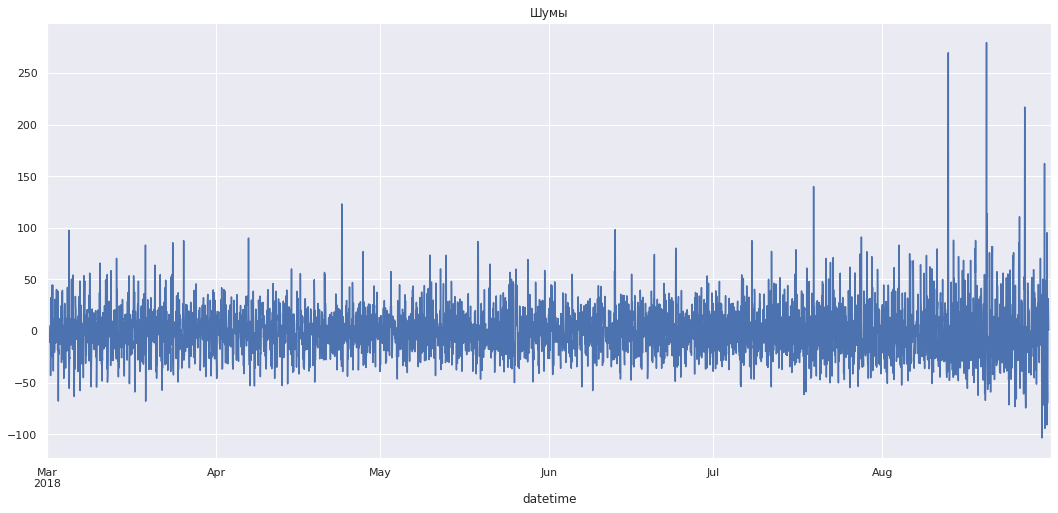

In [14]:
lineplot(decomposed.resid, 'Шумы')

Из этого графика можно понять, что дисперсия временного ряда со временем увеличивается. 

**Вывод:** количество данных, то есть заказов такси, со временем увеличивается => тренд восходящий. Дисперсия временного ряда не постоянна, он тоже растет. Присутствует сезонность: ярко выражены недельная и дневная.



## Обучение

### Подготовка признаков

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)
    
    return data

Так как наблюдается дневная сезонность, лаг и скользящее среднее выберем 24. В случае, если это значение по итогу расчета метрик будет неподходящим, будем его увеличивать

In [16]:
data = df.copy()
data = make_features(data, 168, 168)

### Разделение на выборки

In [17]:
features = data.drop(['num_orders'], axis=1) # выделение признаков
target = data['num_orders']

Обучать модель будем на тренировочной выборке, которая составляет 80% всего датасета, проверять качество модели на валидационной (10%), а конечный результат оценивать на тестовой (10%)

In [18]:
features_train, features_temp, target_train, target_temp = train_test_split(
    features, target, shuffle=False, test_size=0.2, random_state=12345)

features_val, features_test, target_val, target_test = train_test_split(
    features_temp, target_temp, shuffle=False, test_size=0.5, random_state=12345)

### Linear Regression

In [19]:
scaler = StandardScaler()

features_train_scaled = scaler.fit_transform(features_train)

features_val_scaled = scaler.transform(features_val)
features_test_scaled = scaler.transform(features_test)

In [20]:
model_lr = LinearRegression()
model_lr.fit(features_train_scaled, target_train)
pred_lr = model_lr.predict(features_val_scaled)

In [21]:
rmse_lr = np.sqrt(mean_squared_error(target_val, pred_lr))
rmse_lr

29.164562268924197

### LGBM

In [22]:
model_lgbm = lgb.LGBMRegressor(random_state=12345)

In [23]:
model_lgbm.fit(features_train, target_train)
pred_lgbm = model_lgbm.predict(features_val)

In [24]:
rmse_lgbm =np.sqrt(mean_squared_error(target_val, pred_lgbm))
rmse_lgbm

30.517577090542385

### Decision Tree Regressor

In [25]:
model_dtr = DecisionTreeRegressor(random_state=12345)

In [26]:
max_depth_options = range(1, 13)
min_samples_split_options = range(2, 11)

best_params = None
best_rmse = float('inf') 

for max_depth in max_depth_options:
    for min_samples_split in min_samples_split_options:
        model_dtr = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, random_state=12345)
        model_dtr.fit(features_train, target_train)
        y_pred = model_dtr.predict(features_val)
        rmse = np.sqrt(mean_squared_error(target_val, y_pred))
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = {'max_depth': max_depth, 'min_samples_split': min_samples_split}

print("Best parameters:", best_params)
print("RMSE on validation set:", best_rmse)

Best parameters: {'max_depth': 4, 'min_samples_split': 2}
RMSE on validation set: 34.927772013283594


### CatBoost

In [27]:
model_cb = CatBoostRegressor(verbose=False, random_state=12345)

In [28]:
model_cb.fit(features_train, target_train)
pred_cb = model_cb.predict(features_val)

In [29]:
rmse_cb = np.sqrt(mean_squared_error(target_val, pred_cb))
rmse_cb

29.97520220826917

Оформим получившиеся значения в таблицу и сравним результаты:

In [30]:
tabledata = [["Linear Regression", '29.16'],
             ["LightGBM", '30.52'],
             ["Decision Tree", '34.93'],
             ["CatBoost", '29.98']]
df = pd.DataFrame(tabledata, columns=["model", 'RMSE_val'])
df = df.set_index('model')
df.index.names = [None]
df

,RMSE_val
Linear Regression,29.16
LightGBM,30.52
Decision Tree,34.93
CatBoost,29.98


Таким образом, самый лучший результат на валидационной выборке показала модель линейной регрессии. Самое время переходить к тестированию!

## Тестирование

Для того, чтобы метрика на тестовых данных была максимально низкой, добавим к тренировочной выборке еще и валидационную, и только после этого оценим результат своих действий на тестовой:

In [31]:
features_combined = np.vstack((features_train, features_val))
target_combined = np.hstack((target_train, target_val))

In [32]:
features_combined_scaled = scaler.fit_transform(features_combined)
features_test_scaled = scaler.transform(features_test)

In [33]:
model_lr.fit(features_combined_scaled, target_combined)

LinearRegression()

In [34]:
predictions_test = model_lr.predict(features_test_scaled)
rmse_test = mean_squared_error(target_test, predictions_test, squared=False)
print(f'RMSE on Test Data: {rmse_test}')

RMSE on Test Data: 34.60128600749573


По итогу RMSE линейной регрессии на тестовых данных стало выше, чем на валидационных, однако все равно значительно ниже, чем максимальное (то есть 48). Лучшая модель выбрана корректно и работает исправно!